# Séries Temporais

Séries temporais são dados que estão relacionados ao tempo. Por exemplo, a cotação de uma ação na bolsa de valores ao longo do tempo, a temperatura de uma cidade ao longo do ano, o número de vendas de um produto ao longo do mês, etc.

In [2]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

Uma série temporal é uma sequência de pontos de dados coletados em intervalos de tempo sucessivos igualmente espaçados. Os dados são organizados por uma marca de tempo. Ela é formada por três componentes: tendência, sazonalidade e resíduo.

* **Tendência**: é a direção geral em que os dados estão se movendo. Pode ser ascendente, descendente ou horizontal (sem tendência).

* **Sazonalidade**: é o padrão de repetição de um ciclo de tempo. Por exemplo, o número de vendas de um produto pode aumentar no final do ano devido às compras de Natal.

* **Resíduo**: é a parte da série temporal que não pode ser explicada pela tendência ou pela sazonalidade.

In [13]:
df_path = 'https://raw.githubusercontent.com/carlosfab/datasets/master/electricity_consumption/Electric_Production.csv'
df = pl.read_csv(df_path)

df = df.select(
    pl.col('DATE').str.to_date('%m-%d-%Y').alias('date'),
    pl.col('Value').alias('value')
)

df.head(5)

date,value
date,f64
1985-01-01,72.5052
1985-02-01,70.672
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [15]:
df.filter(
    pl.col('date').dt.year() == 1985
)

date,value
date,f64
1985-01-01,72.5052
1985-02-01,70.672
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
1985-06-01,58.0904
1985-07-01,62.6202
1985-08-01,63.2485
1985-09-01,60.5846


Vamos visualizar nossa série temporal

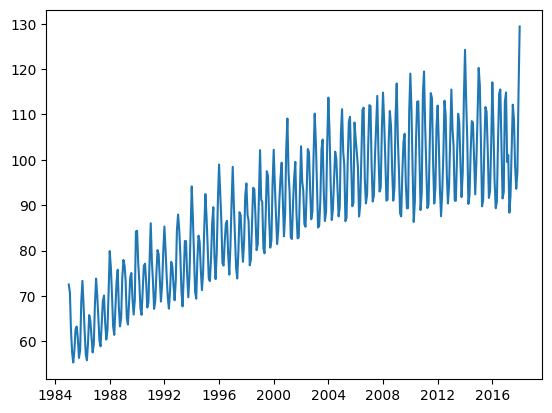

In [16]:
plt.plot(df['date'], df['value'])

Vamos agora decompor a série temporal em suas componentes

In [19]:
result = seasonal_decompose(df.to_pandas().set_index('date'))

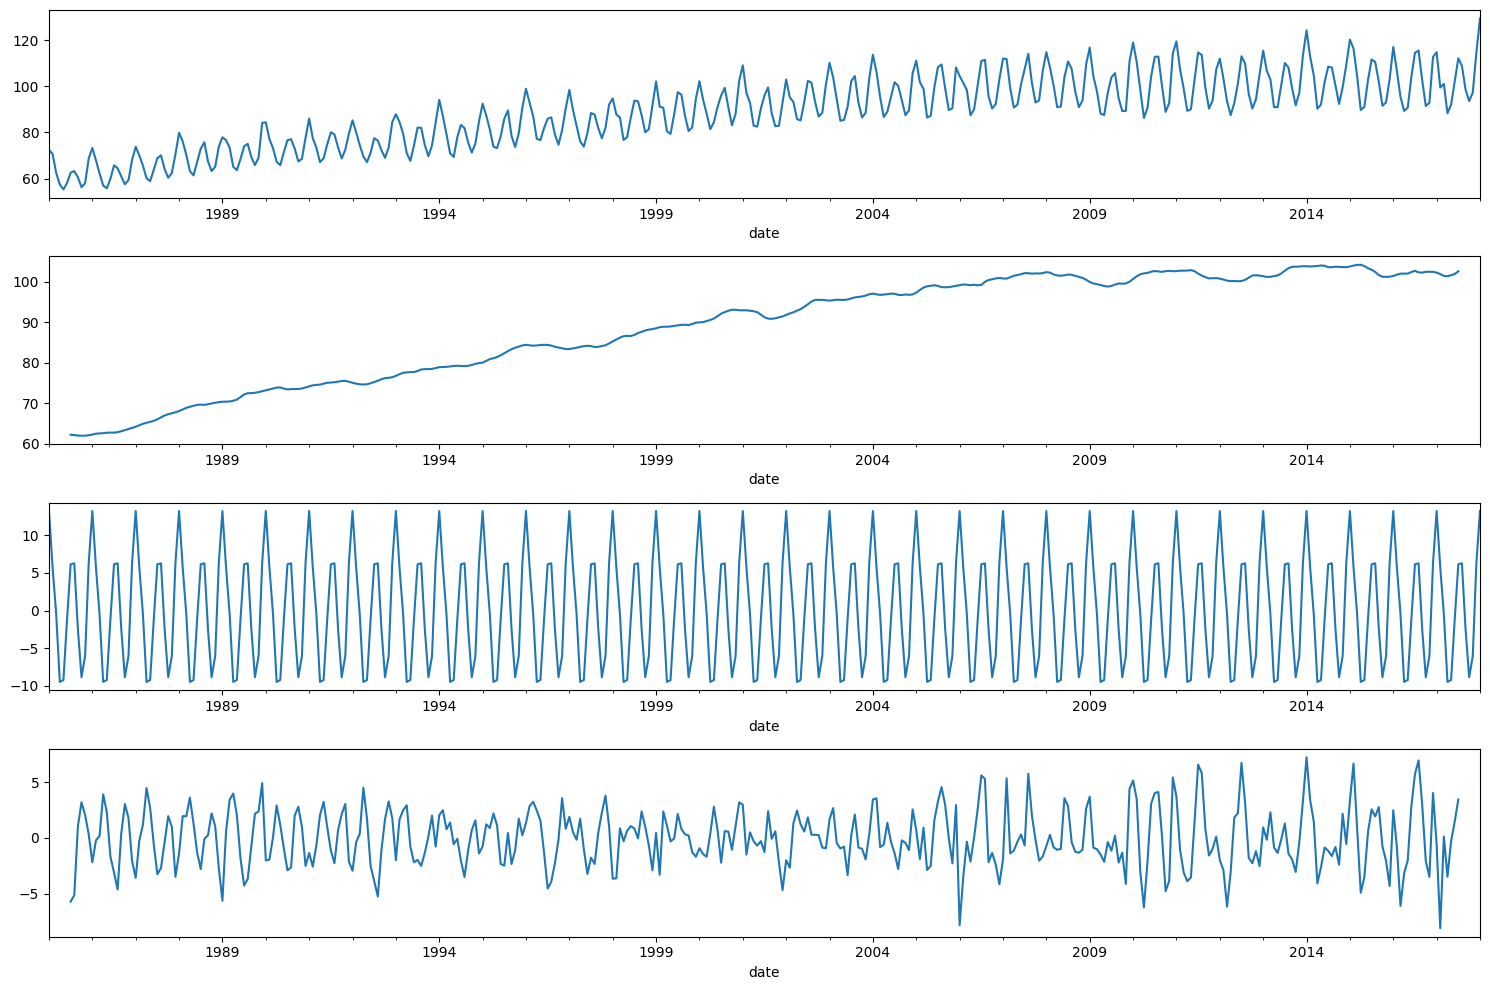

In [21]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,10))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

plt.tight_layout()

## Séries Temporais Estacionárias e Não Estacionárias

Uma série temporal é estacionária se sua média, variância e covariânica não variam com o tempo, são constantes.

A maioria dos modelos de séries temporais assume que a série é estacionária. Se uma série temporal não for estacionária, ela deve ser transformada em uma série estacionária antes de aplicar determinados modelos.

Para verificar se uma série temporal é estacionária, podemos usar o teste de Dickey-Fuller aumentado (ADF). A hipótese nula ($H_0$) do teste é que a série temporal não é estacionária e a hipótese alternativa ($H_1$) é que a série temporal é estacionária.

In [25]:
from statsmodels.tsa.stattools import adfuller

sns.set_style('darkgrid')

X = df['value'].to_numpy()
result = adfuller(X)

print(f'ADF Statistic: {result[0]}')
print(f'P-value: {result[1]}')

print(f'Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.256990350047244
P-value: 0.18621469116586792
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Como podemos ver, o valor-p é maior que 0,05, portanto, não podemos rejeitar a hipótese nula. Isso significa que a série temporal não é estacionária. 

Iremos aplicar uma transformação para tornar a série estacionária. Uma das transformações mais comuns é a transformação logarítmica.

Primeiro vamos visualizar a série temporal com a média móvel de 12 meses

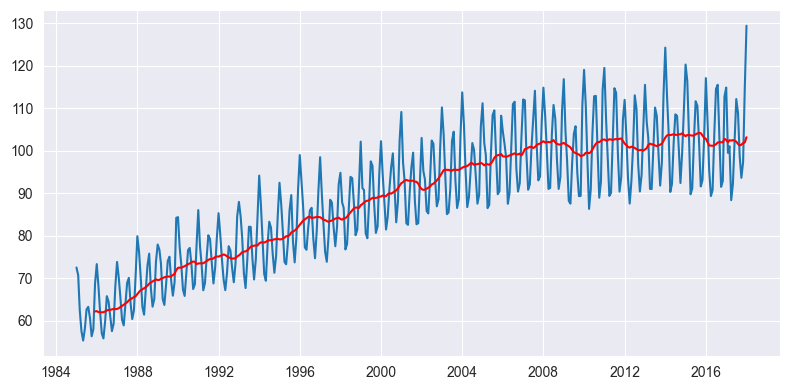

In [31]:
df_aux = df.with_columns(
    pl.col('value').rolling_mean(12).alias('ma_12')
)

f, ax = plt.subplots(figsize=(8,4))

ax.plot(df['date'], df['value'], label='Original')
ax.plot(df['date'], df_aux['ma_12'], color='red', label='MA 12')

plt.tight_layout()

Agora vamos aplicar a transformação logarítmica e visualizar a série temporal com a média móvel de 12 meses novamente. Podemos perceber que a tendência não foi alterada porém a escala foi reduzida.

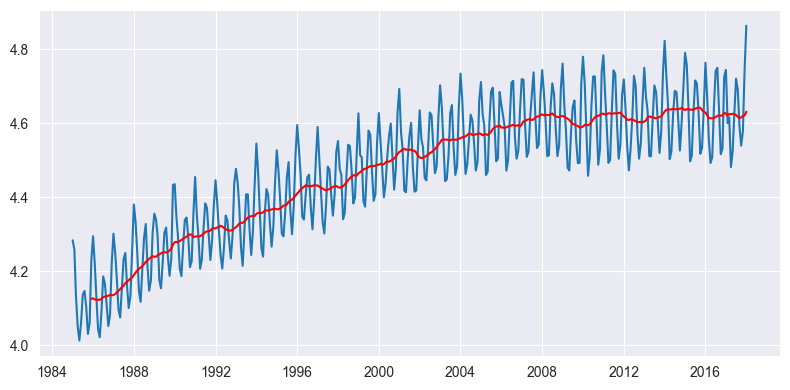

In [34]:
df_aux = df.with_columns(
    pl.col('value').log().alias('log_value')
).with_columns(
    pl.col('log_value').rolling_mean(12).alias('ma_12')
)

f, ax = plt.subplots(figsize=(8,4))

ax.plot(df_aux['date'], df_aux['log_value'], label='Log')
ax.plot(df_aux['date'], df_aux['ma_12'], color='red', label='MA 12')

plt.tight_layout()

Agora vamos subtrair a média móvel da série temporal e visualizar a série temporal com a média móvel de 12 meses novamente. Podemos perceber que a tendência foi removida.

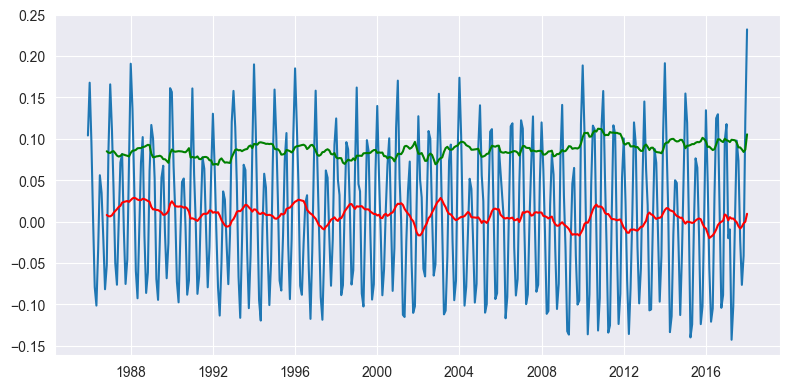

In [45]:
df_aux = (
    df.with_columns(
        pl.col('value').log().alias('log_value')
    )
    .with_columns(
        pl.col('log_value').rolling_mean(12).alias('ma_12')
    )
    .drop_nulls()
    .with_columns(
        (pl.col('log_value') - pl.col('ma_12')).alias('log_sub')
    ).with_columns(
        pl.col('log_sub').rolling_mean(12).alias('ma_12_sub'),
        pl.col('log_sub').rolling_std(12).alias('std_12_sub'),
    )
)

f, ax = plt.subplots(figsize=(8,4))

ax.plot(df_aux['date'], df_aux['log_sub'])
ax.plot(df_aux['date'], df_aux['ma_12_sub'], color='red')
ax.plot(df_aux['date'], df_aux['std_12_sub'], color='green')

plt.tight_layout()

Agora vamos verificar se a série temporal foi transformada em estacionária.

In [46]:
X = df_aux['log_sub'].to_numpy()
result = adfuller(X)

print(f'ADF Statistic: {result[0]}')
print(f'P-value: {result[1]}')

print(f'Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.211586185365467
P-value: 8.32563975994506e-06
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Conseguimos transformar a série temporal em estacionária.

Podemos deixar mais "estacionária" aplicando a diferenciação. Vamos aplicar a diferenciação de primeira ordem e visualizar a série temporal com a média móvel de 12 meses novamente.

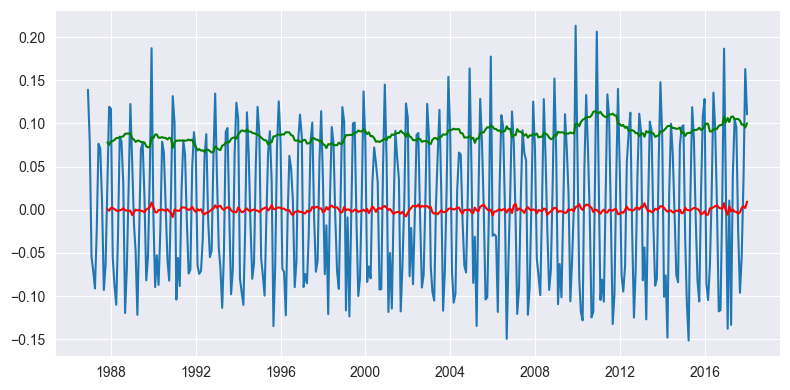

In [54]:
df_aux = df_aux.with_columns(
    pl.col('log_sub').diff(1).alias('diff_log_sub')
).drop_nulls().with_columns(
    pl.col('diff_log_sub').rolling_mean(12).alias('diff_log_sub_ma'),
    pl.col('diff_log_sub').rolling_std(12).alias('diff_log_sub_std')
)

f, ax = plt.subplots(figsize=(8,4))

ax.plot(df_aux['date'], df_aux['diff_log_sub'])
ax.plot(df_aux['date'], df_aux['diff_log_sub_ma'], color='red')
ax.plot(df_aux['date'], df_aux['diff_log_sub_std'], color='green')

plt.tight_layout()


In [55]:
X = df_aux['diff_log_sub'].to_numpy()
result = adfuller(X)

print(f'ADF Statistic: {result[0]}')
print(f'P-value: {result[1]}')

print(f'Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.6184630214284095
P-value: 2.1600950313830386e-11
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
